In [ ]:
# install dependencies
! pip install pandas sklearn numerapi
! pip install catboost

     |████████████████████████████████| 66.1MB 61kB/s 


# Loading

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import numerapi
import sklearn.linear_model
import matplotlib.pylab as plt

from datetime import timedelta
import tqdm

In [2]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [3]:
# download the latest training dataset (takes around 30s)
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [4]:
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [5]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

In [6]:
# select those columns out of the training dataset
training_features = training_data[feature_cols]

In [25]:
target = training_data['target']

In [28]:
eras = training_data['era']
eras_live = tournament_data.era

In [29]:
N_ERAS_IN_FOLD = 12
N_FOLDS = int(len(eras.unique()) / N_ERAS_IN_FOLD)

eras2_binned = []
current_era = 1
thresh_era_limit = N_ERAS_IN_FOLD
for era in eras:
    era_num = int(era.split('era')[-1])
    if era_num <= thresh_era_limit:
        eras2_binned.append(current_era)
    else:
        current_era += 1
        thresh_era_limit += N_ERAS_IN_FOLD
        eras2_binned.append(current_era)

In [30]:
validation_ids = tournament_data.data_type=='validation'

# Feature Importance

In [31]:
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn import model_selection

from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product

In [33]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [34]:
REFERENCES = [0.0, 0.25, 0.5, 0.75, 1.0]

In [35]:
def get_base_model(cw = {0: 1,
                          1: 1.1,
                          2: 1,
                          3: 1.1,
                          4: 1
                        }):
    return RidgeClassifier(alpha = 1, 
                           class_weight = cw
                                    )
    
def ridge_classifier_2single_prediction(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

def train_model(X_train, Y_train, model = None):
    if model == None:
        model_i = get_base_model()
    else:
        model_i = model
    model_i.fit(X_train, Y_train)
    return model_i

def calculate_score(train_data, predictions, eras):

    ns = numerai_score(train_data, pd.Series(predictions))
    cs = correlation_score(train_data, pd.Series(predictions))

    df2 = pd.DataFrame(
        {
            "era": eras,
            "preds": predictions,
            "target": train_data
        }
    )

    scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

    per_era_score, per_era_std = scores_per_era.mean(), scores_per_era.std()
    sharpe_era_score = scores_per_era.mean() / scores_per_era.std()
    return ns, cs, per_era_score, per_era_std, sharpe_era_score


def ridge2probas(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    return predictions_proba

def softmax2singlescore(predictions_proba):
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

# Baseline

In [36]:
validation_ids = tournament_data.data_type=='validation'
tournament_data = tournament_data[validation_ids]

In [37]:
le = LabelEncoder()

X = training_features
Y = le.fit_transform(target)
Y_nmr = target

In [38]:
X_test = tournament_data[feature_cols]
Y_test = le.fit_transform(tournament_data.target)
Y_nmr_test = tournament_data.target
test_eras = tournament_data.era

In [39]:
clf = get_base_model()
clf.fit(X, Y)
pred_c = clf.predict(X_test)
pred = ridge_classifier_2single_prediction(clf, X_test)

In [40]:
print(classification_report(pred_c, Y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.23      0.01       709
           2       0.99      0.50      0.67    135810
           3       0.01      0.23      0.02      1260
           4       0.00      0.00      0.00         0

    accuracy                           0.50    137779
   macro avg       0.20      0.19      0.14    137779
weighted avg       0.98      0.50      0.66    137779



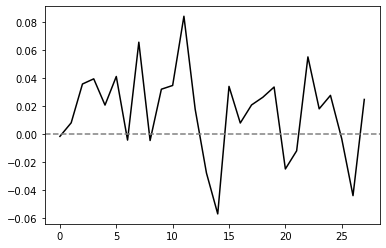

0.015581439471059536 0.015413564772967979 0.015983388686390602 0.03136490170397082 0.5095947322661972


In [41]:
ns_bs = numerai_score(Y_nmr_test, pd.Series(pred))
cs_bs = correlation_score(Y_nmr_test, pd.Series(pred))

df2 = pd.DataFrame(
    {
        "era": test_eras,
        "preds": pred,
        "target": Y_nmr_test
    }
)

scores_per_era_bs = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

per_era_score, per_era_std = scores_per_era_bs.mean(), scores_per_era_bs.std()
sharpe_era_score = scores_per_era_bs.mean() / scores_per_era_bs.std()

plt.figure()
plt.plot(scores_per_era_bs.values, color = 'black')
plt.axhline(0.0, ls = '--', color = 'grey')
plt.show()
print(ns_bs, cs_bs, per_era_score, per_era_std, sharpe_era_score)

# Feature Importance

In [63]:
def featImpMDA(X, y, cv, eras_groups):

    cvGen = model_selection.GroupKFold(cv)
    X_old = X.copy()
    scr0,scr1=pd.Series(), pd.DataFrame(columns=X.columns)

    for i, (train,test) in tqdm.tqdm(enumerate(cvGen.split(X=X, groups = eras_groups))):

        if i > 3:
            break

        X0, y0 = X.iloc[train, :], y[train]
        X1, y1 = X.iloc[test, :], y[test] 
        # eras_test = pd.Series(eras2_binned).iloc[test]
        eras_test = pd.Series(eras_groups).iloc[test]

        clf = get_base_model()
        clf.fit(X=X0,y=y0)
        y1 = le.inverse_transform(y1)

        # pred = fit.predict(X1)
        pred = ridge_classifier_2single_prediction(clf, X1)

        # scr0.loc[i]=correlation_score(y1,pred)
        sharpes_metrics = calculate_score(y1, pred, eras_test)
        scr0.loc[i] = sharpes_metrics[0]

        for j in X.columns:

            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column

            pred_shuffled = ridge_classifier_2single_prediction(clf, X1_)

            # scr1.loc[i,j]=correlation_score(y1,pred_shuffled)
            sharpes_metrics_shuffled = calculate_score(y1, pred_shuffled, eras_test)
            scr1.loc[i,j] = sharpes_metrics_shuffled[0]

    imp=(-scr1).add(scr0,axis=0)
    imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    #imp,scr0.mean()
    return scr1, scr0

In [76]:
for j in X.columns:
    X1_ = X1.copy(deep=True)
    np.random.shuffle(X1_[j].values) # permutation of a single column
    pred_shuffled = ridge_classifier_2single_prediction(clf, X1_)

    # scr1.loc[i,j]=correlation_score(y1,pred_shuffled)
    sharpes_metrics_shuffled = calculate_score(y1, pred_shuffled, eras_test)
    scr1.loc[i,j] = sharpes_metrics_shuffled[0]

In [77]:
scr1

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
2,0.0427556,0.0403414,0.0412436,0.0432153,0.0454432,0.0449987,0.0443145,0.0459347,0.042114,0.0450247,...,0.0453063,0.0436154,0.0449107,0.0451331,0.0449791,0.0439055,0.0451715,0.0450675,0.0450665,0.0448353


# Selecting Important Features
## 1/2 train set

In [64]:
X_FOR_FEATURE_IMPORTANCE = X[:int(len(X)/2)]
Y_FOR_FEATURE_IMPORTANCE = Y[:int(len(Y)/2)]
ERAS_FOR_FI = eras2_binned[:int(len(eras2_binned)/2)]

In [65]:
scr_1, scr_0 = featImpMDA(X=X_FOR_FEATURE_IMPORTANCE, 
                                y=Y_FOR_FEATURE_IMPORTANCE,
                                cv = 5,
                                eras_groups = ERAS_FOR_FI)

0it [00:00, ?it/s]random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
random shuffle single column: None
ra

KeyboardInterrupt: 

In [ ]:
scr_0

In [47]:
#  importances, oos = featImpMDA(X=X_FOR_FEATURE_IMPORTANCE, 
#                                y=Y_FOR_FEATURE_IMPORTANCE,
#                                cv = 5,
#                                eras_groups = ERAS_FOR_FI)

0it [00:05, ?it/s]


KeyboardInterrupt: 

In [ ]:
# importances_more_zero = importances[importances['mean'] - importances['std']  > 0]
# importances_more_zero['mean_std_diff'] = importances_more_zero['mean'] - importances_more_zero['std']
importances_more_zero = importances[importances['mean']  > 0]
# importances_more_zero = importances.sort_values('mean')[::-1]

In [ ]:
DOWN, UP = 0, 100
COLUMN = 'mean'

In [ ]:
# importances_more_zero.sort_values('mean')[::-1].plot.bar(figsize = (40, 10))

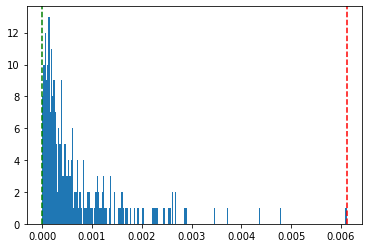

In [ ]:
plt.figure()
plt.hist(importances_more_zero[COLUMN].values, bins = len(importances_more_zero))
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, UP), ls = '--', color = 'red')
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, DOWN), ls = '--', color = 'green')
plt.show()

In [ ]:
up_limit = np.percentile(importances_more_zero[COLUMN].values, UP)
bot_limit = np.percentile(importances_more_zero[COLUMN].values, DOWN)
bot_limit, up_limit

(2.937597982260151e-06, 0.0061110641938244585)

In [ ]:
mask = (importances_more_zero[COLUMN] < up_limit) & (importances_more_zero[COLUMN] > bot_limit)
IMPORTANT_FEATURES = importances_more_zero[mask].index.tolist()
len(IMPORTANT_FEATURES)

244

# Re-Balance the Class Weights

In [ ]:
X_FOR_CV = X[int(len(X)/2):]
Y_FOR_CV = Y[int(len(Y)/2):]

ERAS_CV = training_data[int(len(training_data)/2):].era
ERAS_CV = ERAS_CV.apply(lambda x: 'era' + str(int(x[3:])-63))
Y_NMR_CV = Y_nmr[int(len(Y_nmr)/2):]

In [ ]:
model_t = get_base_model(   
        cw = {
            0: 1,
            1: 1.1,
            2: 1,
            3: 1.1,
            4: 1
        }
    )
model_t = train_model(X_FOR_CV[IMPORTANT_FEATURES], Y_FOR_CV, model_t)
pred = model_t.predict(X_FOR_CV[IMPORTANT_FEATURES])

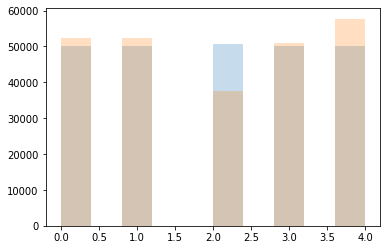

In [ ]:
plt.figure()
plt.hist(Y_FOR_CV, alpha = 0.25)
plt.hist(pred, alpha = 0.25)
plt.show()

# Cross-validation

In [ ]:
class PurgeCVByEras(model_selection.BaseCrossValidator):

    def __init__(self, eras, n_eras_train, n_eras_test, embargo, era_prefix = 'era'):
        self.eras = eras
        self.n_eras = len(eras.unique())
        self.era_prefix = era_prefix
        self.n_eras_train = n_eras_train
        self.n_eras_test = n_eras_test
        self.embargo = embargo

    def get_indices_of_era(self, era):
        era_str = self.era_prefix + str(era)
        return self.eras.index[self.eras == era_str].tolist()

    def split(self, X=None, y=None, groups=None):
        for i in range(0, self.n_eras, (self.n_eras_train + self.n_eras_test + self.embargo)):
            train_eras = [i+n for n in range(self.n_eras_train)]
            test_eras = [i+m+self.n_eras_train+self.embargo for m in range(self.n_eras_test)]
            train_indices = []

            test_limit = 0
            if max(train_eras) >= self.n_eras:
                break
            elif max(test_eras) >= self.n_eras:
                max_index = test_eras.index(max(test_eras))
                test_eras = test_eras[:max_index]

            for e in train_eras:
                e_indices = self.get_indices_of_era(e)
                train_indices.extend(e_indices)

            test_indices = []
            for e in test_eras:
                e_indices = self.get_indices_of_era(e)
                test_indices.extend(e_indices)

            yield(train_indices, test_indices)        

    def get_n_splits(self):
        return len(range(0, self.n_eras, (self.n_eras_train + self.n_eras_test + self.embargo)))

In [ ]:
class BlockingTimeSeriesSplit():

    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from catboost import CatBoostClassifier, Pool, cv

In [ ]:
alpha, beta = 1, 1 # scaling of the tanh function (the higher - the most "rough")
def temperature_function(x, alpha=alpha, beta=beta, mi=0.01, ma=10):
    return np.clip(alpha * -np.tanh(x * beta) + 1, mi, ma)

def train_meta_labeler(X, Y_proba, Y_target):
    meta_labels = np.array(
          [p == t for p, t in zip(np.argmax(Y_proba, axis=1), Y_target)], dtype = np.int16
      )
    model_meta = CatBoostClassifier(
          custom_loss=['Logloss'],
          random_seed=42,
          iterations = 25,
          logging_level = 'Silent'
      )
    model_meta.fit(
        X, meta_labels
    )
    meta_predictions = model_meta.predict(X)
    meta_predictions_proba = model_meta.predict_proba(X)
    mean_meta_prob = np.mean(meta_predictions_proba[:, 1])
    return model_meta, mean_meta_prob

def normal_labels_to_meta_labels(predictions_proba_live, predictions_proba_live_meta, mean_meta_prob):
    predictions_proba_live_comb = []
    for pred_proba_live, pred_proba_live_meta in zip(predictions_proba_live, predictions_proba_live_meta[:, 1]):
        x = pred_proba_live_meta - mean_meta_prob
        temperature = temperature_function(x) # calculation of the trust temperature
        res = np.exp(pred_proba_live / temperature) / np.sum(np.exp(pred_proba_live / temperature)) # rescaling to sum up to 1.0
        predictions_proba_live_comb.append(res)
    predictions_proba_live_comb = np.array(predictions_proba_live_comb)
    return predictions_proba_live_comb

In [ ]:
def cross_validate(cross_validator, X, Y, Y_nmr, eras, meta = True):

    all_sharpes = []
    for train_ids, test_ids in cross_validator.split(X, Y, groups = eras):


        X_train, X_test = X.values[train_ids], X.values[test_ids]
        Y_train, Y_test = Y[train_ids], Y[test_ids]
        eras_train, eras_test = eras.values[train_ids], eras.values[test_ids]

        pca = PCA(0.999)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

        model_i = get_base_model(cw = {
                                    0: 1,
                                    1: 1.1,
                                    2: 1,
                                    3: 1.1,
                                    4: 1
                                })
        model_i = train_model(X_train, Y_train, model_i)
        single_score_predictions = ridge_classifier_2single_prediction(model_i, X_test)

        if meta:
          
            Y_prob = model_i.decision_function(X_train)
            model_meta, mean_meta_prob = train_meta_labeler(X_train, Y_prob, Y_train)
            meta_labels = model_meta.predict_proba(X_test)
            pred_proba = ridge2probas(model_i, X_test)

            predictions_proba_live_comb = []
            for pred_proba_live, pred_proba_live_meta in zip(pred_proba, meta_labels[:, 1]):
                x = pred_proba_live_meta - mean_meta_prob
                temperature = temperature_function(x) # calculation of the trust temperature
                res = np.exp(pred_proba_live / temperature) / np.sum(np.exp(pred_proba_live / temperature)) # rescaling to sum up to 1.0
                predictions_proba_live_comb.append(res)
            predictions_proba_live_comb = np.array(predictions_proba_live_comb)
            single_score_predictions = softmax2singlescore(predictions_proba_live_comb)

        sharpe = calculate_score(
            train_data = Y_nmr[test_ids], 
            predictions = single_score_predictions,
            eras = eras_test)

        all_sharpes.append(sharpe)

    return np.array(all_sharpes)

### CV on all features 2/2 train set

In [ ]:
np.random.seed(0)

In [ ]:
# cvs = {
#     # "GroupKFold": model_selection.GroupKFold(5),
#     "TimeSeriesSplit": model_selection.TimeSeriesSplit(5),
#     "BlockingTimeSeriesSplit": BlockingTimeSeriesSplit(5),
#     "PurgeCVByEras" : PurgeCVByEras(ERAS_CV.reset_index(drop=True), 12, 12, 6)
#   }

# for cv in cvs.keys():
#     sharpes = cross_validate(cvs[cv], 
#                              X_FOR_CV.reset_index(drop=True), 
#                              Y_FOR_CV, 
#                              Y_NMR_CV.reset_index(drop=True).values, 
#                              ERAS_CV)
#     ns = sharpes[:, 0]
#     cs = sharpes[:, 1]
#     per_era_score = sharpes[:, 2]
#     per_era_std = sharpes[:, 3]
#     sharpe_era_score = sharpes[:, 4]
#     print(cv)
#     print('Numerai Score', np.mean(ns), np.std(ns))
#     print('Correlation Score', np.mean(cs), np.std(cs))
#     print('Per-Era Correlation', np.mean(per_era_score), np.std(per_era_score))
#     print('Per-Era Standard Deviation', np.mean(per_era_std), np.std(per_era_std))
#     print('Per-Era Sharpe Ratio', np.mean(sharpe_era_score), np.std(sharpe_era_score))
#     print('-' * 10)

### CV on important features 2/2 train set

In [ ]:
cvs = {
    # "GroupKFold": model_selection.GroupKFold(5),
    "TimeSeriesSplit": model_selection.TimeSeriesSplit(5),
    "BlockingTimeSeriesSplit": BlockingTimeSeriesSplit(5),
    "PurgeCVByEras" : PurgeCVByEras(ERAS_CV.reset_index(drop=True), 12, 12, 6)
  }

for cv in cvs.keys():
    sharpes = cross_validate(cvs[cv], 
                             X_FOR_CV[IMPORTANT_FEATURES].reset_index(drop=True), 
                             Y_FOR_CV, 
                             Y_NMR_CV.reset_index(drop=True).values, 
                             ERAS_CV,
                             True)
    ns = sharpes[:, 0]
    cs = sharpes[:, 1]
    per_era_score = sharpes[:, 2]
    per_era_std = sharpes[:, 3]
    sharpe_era_score = sharpes[:, 4]
    print(cv)
    print('Numerai Score', np.mean(ns), np.std(ns))
    print('Correlation Score', np.mean(cs), np.std(cs))
    print('Per-Era Correlation', np.mean(per_era_score), np.std(per_era_score))
    print('Per-Era Standard Deviation', np.mean(per_era_std), np.std(per_era_std))
    print('Per-Era Sharpe Ratio', np.mean(sharpe_era_score), np.std(sharpe_era_score))
    print('-' * 10)

TimeSeriesSplit
Numerai Score 0.020318859316360113 0.010561771870042695
Correlation Score 0.02185705143098694 0.010429330477348788
Per-Era Correlation 0.022048919410545813 0.009499389370344615
Per-Era Standard Deviation 0.032204401941200854 0.013183080597013822
Per-Era Sharpe Ratio 0.7200799834289351 0.33071879229488443
----------
BlockingTimeSeriesSplit
Numerai Score 0.015977856057554203 0.014485986317520861
Correlation Score 0.01663562823617133 0.014429622992557118
Per-Era Correlation 0.019753114507429233 0.014581750976699857
Per-Era Standard Deviation 0.0267098272578788 0.008089381023005696
Per-Era Sharpe Ratio 0.8133886662327287 0.729190272492613
----------
PurgeCVByEras
Numerai Score 0.016126950381312063 0.006969447086941606
Correlation Score 0.016583421206554434 0.006457549335012183
Per-Era Correlation 0.01666164826113978 0.006511106656737055
Per-Era Standard Deviation 0.02215798921812429 0.00032014207991064303
Per-Era Sharpe Ratio 0.7563511315632362 0.30477704518488585
---------

In [ ]:
# TimeSeriesSplit
# Numerai Score 0.01925462046015627 0.009945674177002841
# Correlation Score 0.020281237978793262 0.009900275688495575
# Per-Era Correlation 0.020351144914288265 0.009558358133184052
# Per-Era Standard Deviation 0.03148433069321672 0.015217252267864998
# Per-Era Sharpe Ratio 0.6763038015393811 0.35337794957104884
# ----------
# BlockingTimeSeriesSplit
# Numerai Score 0.017357464096510865 0.012836981320395383
# Correlation Score 0.017920222716025697 0.013369830409459603
# Per-Era Correlation 0.02190719592987754 0.013944126615746757
# Per-Era Standard Deviation 0.026080775818348077 0.007932714138070066
# Per-Era Sharpe Ratio 0.8948490467333936 0.6466697114680272
# ----------
# PurgeCVByEras
# Numerai Score 0.013242613898943342 0.00766841254656926
# Correlation Score 0.013190882038723603 0.007379940144351194
# Per-Era Correlation 0.013255279242168322 0.007459466336770321
# Per-Era Standard Deviation 0.020017224014070682 0.0018776388099172505
# Per-Era Sharpe Ratio 0.6328063004037553 0.3132944240202242
# ----------

In [ ]:
# TimeSeriesSplit
# Numerai Score 0.02097256380133245 0.010013304793910693
# Correlation Score 0.022389722781826167 0.009915355575225753
# Per-Era Correlation 0.02271200354105003 0.008879267635339095
# Per-Era Standard Deviation 0.03354371473178732 0.012071340946551126
# Per-Era Sharpe Ratio 0.6975813447369505 0.280578880285802
# ----------
# BlockingTimeSeriesSplit
# Numerai Score 0.017714859461851987 0.015647730336606373
# Correlation Score 0.01866113165931573 0.01580110304774684
# Per-Era Correlation 0.021961981979271815 0.016443722898939354
# Per-Era Standard Deviation 0.02597788186077334 0.006730381851703717
# Per-Era Sharpe Ratio 0.8857505026078005 0.7612270120539839
# ----------
# PurgeCVByEras
# Numerai Score 0.014262925641734505 0.0060517181791186056
# Correlation Score 0.014860589337502828 0.006240294463612156
# Per-Era Correlation 0.014969936884651858 0.006338905390379263
# Per-Era Standard Deviation 0.02290642946126601 0.0006344368680178351
# Per-Era Sharpe Ratio 0.6616977204423878 0.2950573694228523
# ----------

In [ ]:
# TimeSeriesSplit
# Numerai Score 0.020925707426224523 0.009978817402474733
# Correlation Score 0.022363503936886325 0.00978196523757409
# Per-Era Correlation 0.022699633265259464 0.008786733091903606
# Per-Era Standard Deviation 0.033550790679720534 0.0120730366336198
# Per-Era Sharpe Ratio 0.6949696052782974 0.27259800172135307
# ----------
# BlockingTimeSeriesSplit
# Numerai Score 0.017583533750837065 0.015516714565264881
# Correlation Score 0.01834605361937234 0.015556431070866263
# Per-Era Correlation 0.02222291121028109 0.01681195828297658
# Per-Era Standard Deviation 0.027082426863812875 0.006963238869225877
# Per-Era Sharpe Ratio 0.8224676837618027 0.6632216252915604
# ----------
# PurgeCVByEras
# Numerai Score 0.014184639073992006 0.005836885339597908
# Correlation Score 0.014899994440039893 0.006357032282929712
# Per-Era Correlation 0.014993982353271557 0.006435644449725583
# Per-Era Standard Deviation 0.02268378052274169 0.0010921198281787486
# Per-Era Sharpe Ratio 0.6762270268475762 0.3162685067819142
# ----------

# Final Validation

In [ ]:
X_test = tournament_data[IMPORTANT_FEATURES]
Y_test = le.fit_transform(tournament_data.target_kazutsugi)
Y_nmr_test = tournament_data.target_kazutsugi
test_eras = tournament_data.era

In [ ]:
clf = get_base_model()
clf.fit(X[IMPORTANT_FEATURES], Y)
pred_c = clf.predict(X_test)
pred = ridge_classifier_2single_prediction(clf, X_test)

In [ ]:
print(classification_report(pred_c, Y_test))

precision    recall  f1-score   support

           0       0.29      0.27      0.28     22644
           1       0.22      0.23      0.22     20593
           2       0.24      0.29      0.26     18140
           3       0.22      0.22      0.22     20640
           4       0.32      0.27      0.29     24878

    accuracy                           0.26    106895
   macro avg       0.26      0.26      0.26    106895
weighted avg       0.26      0.26      0.26    106895



In [ ]:
X_test.shape, pred.shape, test_eras.shape

((106895, 244), (106895,), (106895,))

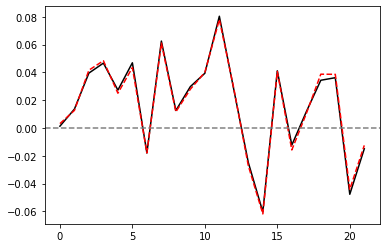

0.016432322340894753 0.016002683882384846 0.016818310521582804 0.03492848494360476 0.4815070149403133


In [ ]:
ns = numerai_score(Y_nmr_test, pd.Series(pred))
cs = correlation_score(Y_nmr_test, pd.Series(pred))

df2 = pd.DataFrame(
    {
        "era": test_eras,
        "preds": pred,
        "target": Y_nmr_test
    }
)

scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

per_era_score, per_era_std = scores_per_era.mean(), scores_per_era.std()
sharpe_era_score = scores_per_era.mean() / scores_per_era.std()

plt.figure()
plt.plot(scores_per_era_bs.values, color = 'black')
plt.plot(scores_per_era.values, ls = '--', color = 'red')
plt.axhline(0.0, ls = '--', color = 'grey')
plt.show()
print(ns, cs, per_era_score, per_era_std, sharpe_era_score)

In [ ]:
IMPORTANT_FEATURES

['feature_intelligence1',
 'feature_intelligence2',
 'feature_intelligence3',
 'feature_intelligence4',
 'feature_intelligence5',
 'feature_intelligence6',
 'feature_intelligence7',
 'feature_intelligence9',
 'feature_intelligence10',
 'feature_intelligence11',
 'feature_charisma2',
 'feature_charisma3',
 'feature_charisma4',
 'feature_charisma5',
 'feature_charisma7',
 'feature_charisma10',
 'feature_charisma11',
 'feature_charisma13',
 'feature_charisma15',
 'feature_charisma16',
 'feature_charisma17',
 'feature_charisma18',
 'feature_charisma19',
 'feature_charisma20',
 'feature_charisma21',
 'feature_charisma22',
 'feature_charisma23',
 'feature_charisma24',
 'feature_charisma25',
 'feature_charisma26',
 'feature_charisma27',
 'feature_charisma28',
 'feature_charisma29',
 'feature_charisma30',
 'feature_charisma31',
 'feature_charisma32',
 'feature_charisma33',
 'feature_charisma34',
 'feature_charisma36',
 'feature_charisma37',
 'feature_charisma39',
 'feature_charisma40',
 'featu

In [ ]:
# 0.016377875621628485 0.01611916480602046 0.016919172393467265 0.035054573477805176 0.48265235359887204

In [ ]:
# 0.016891909006799235 0.01645011349547171 0.017219044707080692 0.035294027287233395 0.48787418242035496

In [ ]:
# 0.01695515820999998 0.0165072009830593 0.017262188559532085 0.03516001888771483 0.49096073055761696